In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Flatten, Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

2022-12-05 19:24:25.626469: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-05 19:24:26.415920: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /app/lib
2022-12-05 19:24:26.415942: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-05 19:24:29.498638: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No s

In [2]:
random_seed = 69
np.random.seed(random_seed)

df = pd.read_csv('munster_hourly.csv', parse_dates=["DATUM"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35672 entries, 0 to 35671
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATUM        35672 non-null  datetime64[ns]
 1   STATIONS_ID  35672 non-null  int64         
 2   QN_4         35672 non-null  int64         
 3   TT_TER       35672 non-null  float64       
 4   RF_TER       35672 non-null  float64       
 5   VGSL         35672 non-null  float64       
 6   TS05         35672 non-null  float64       
 7   BF10         35672 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3)
memory usage: 2.2 MB


In [3]:
df = df[['DATUM', ]]

[1766]


/tmp/ipykernel_3166/1726528945.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(['STATIONS_ID'], 1)


,DATUM,QN_4,TT_TER,RF_TER,VGSL,TS05,BF10
0,1991-01-01 07:00:00,10,3.0,91.0,0.3,2.9,102
1,1991-01-01 14:00:00,10,4.8,85.0,0.3,2.9,102
2,1991-01-01 21:00:00,10,3.9,82.0,0.3,2.9,102
3,1991-01-02 07:00:00,10,5.6,94.0,1.4,6.3,110
4,1991-01-02 14:00:00,10,11.0,87.0,1.4,6.3,110
...,...,...,...,...,...,...,...
35667,2021-12-30 00:00:00,1,11.6,90.0,0.8,9.4,104
35668,2021-12-30 06:00:00,1,11.1,98.0,0.8,9.4,104
35669,2021-12-30 12:00:00,1,14.3,83.0,0.8,9.4,104
35670,2021-12-30 18:00:00,1,13.5,90.0,0.8,9.4,104


In [4]:
reindexed_df = df.copy()
reindexed_df.DATUM = reindexed_df.DATUM.astype('datetime64[ns]')
reindexed_df = reindexed_df.groupby(pd.Grouper(key='DATUM', axis=0, freq='D', sort=True)).mean()

reindexed_df

,QN_4,TT_TER,RF_TER,VGSL,TS05,BF10
DATUM,,,,,,
1991-01-01,10.0,3.900000,86.000000,0.3,2.9,102.0
1991-01-02,10.0,9.200000,90.666667,1.4,6.3,110.0
1991-01-03,10.0,7.733333,82.333333,1.0,6.6,110.0
1991-01-04,10.0,6.433333,76.666667,1.2,5.5,106.0
1991-01-05,10.0,5.466667,78.000000,1.0,3.7,109.0
...,...,...,...,...,...,...
2021-12-27,1.0,3.050000,87.750000,0.1,-0.1,97.0
2021-12-28,1.0,6.700000,92.250000,0.2,0.5,104.0
2021-12-29,1.0,7.900000,96.250000,0.3,5.4,107.0


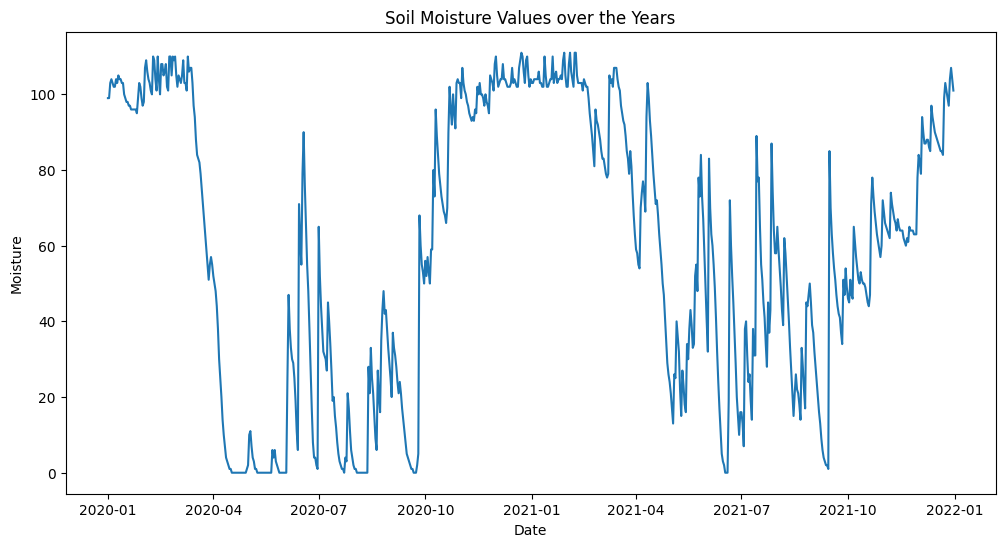

In [5]:
plt.figure(figsize=(12,6))
plt.title('Soil Moisture Values over the Years')
plt.xlabel('Date')
plt.ylabel('Moisture')
plt.plot(reindexed_df['BF10']['2020-01-01':])

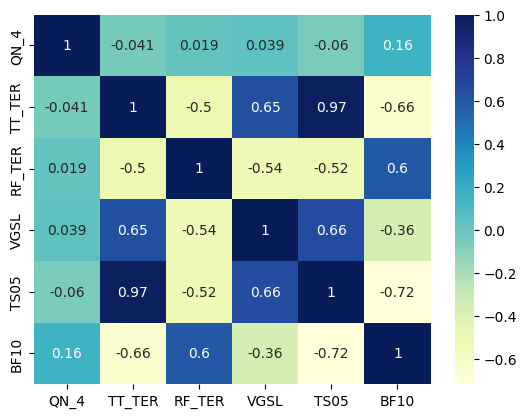

In [6]:
sns.heatmap(reindexed_df.corr(), cmap="YlGnBu", annot=True)
plt.show()

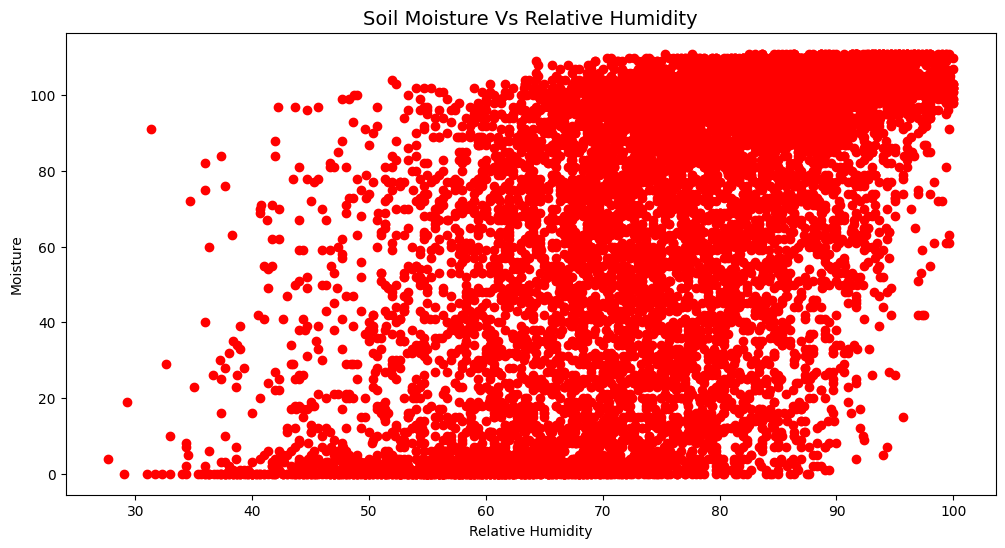

In [7]:
reindexed_df = reindexed_df[reindexed_df.RF_TER > 0]

plt.figure(figsize=(12,6))
plt.scatter(x = reindexed_df['RF_TER'], y = reindexed_df['BF10'], color='red')
plt.title('Soil Moisture Vs Relative Humidity', fontsize=14)
plt.xlabel('Relative Humidity')
plt.ylabel('Moisture')
plt.show()

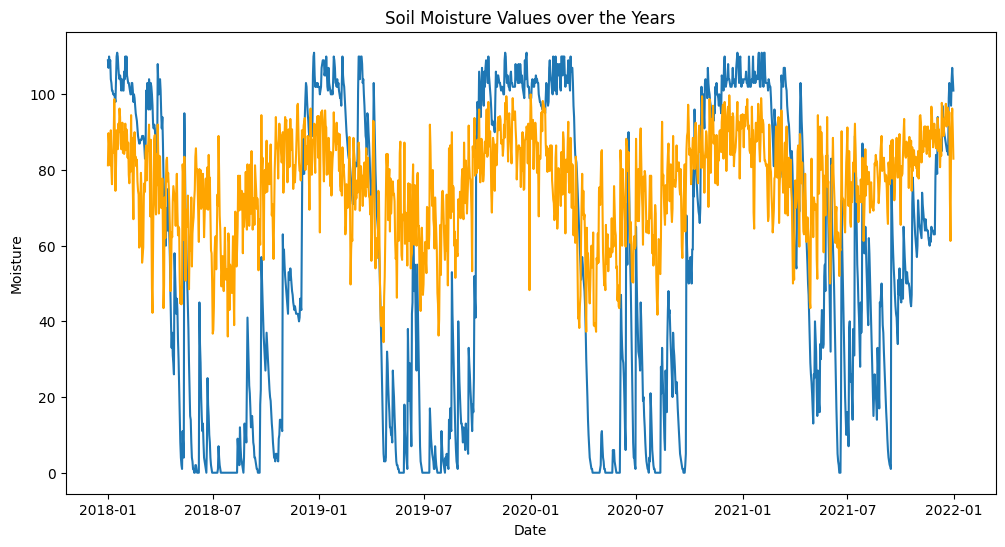

In [8]:
plt.figure(figsize=(12,6))
plt.title('Soil Moisture Values over the Years')
plt.xlabel('Date')
plt.ylabel('Moisture')
plt.plot(reindexed_df['BF10']['2018':])
plt.plot(reindexed_df['RF_TER']['2018':], c='orange')

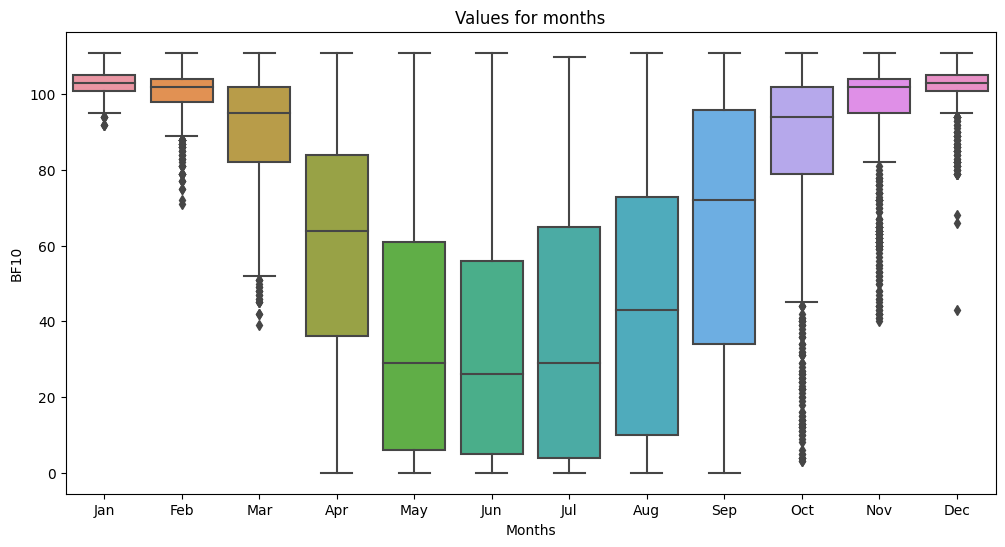

In [9]:
fig, ax = plt.subplots(figsize=(12,6))

sns.boxplot(x=reindexed_df.index.strftime("%b"), y=reindexed_df["BF10"], ax=ax)
plt.title("Values for months")
plt.xlabel("Months")
plt.show()

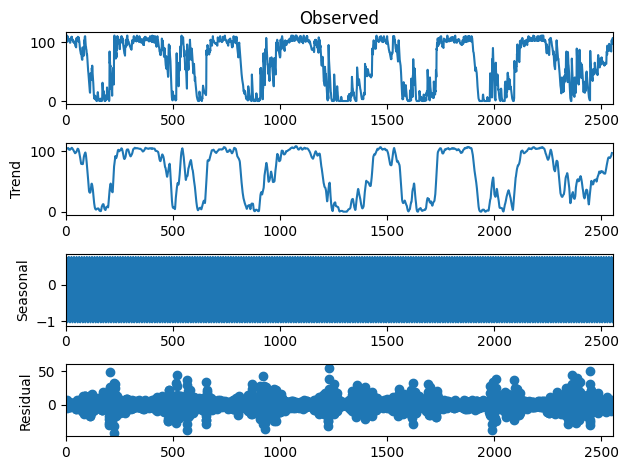

In [11]:
future_days = 30

df2 = reindexed_df[['BF10']]
df2['BF10-Shifted'] = reindexed_df[['BF10']].shift(-future_days)
df2

/tmp/ipykernel_3166/1346759709.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['BF10-Shifted'] = reindexed_df[['BF10']].shift(-future_days)


,BF10,BF10-Shifted
DATUM,,
1991-01-01,102.0,98.0
1991-01-02,110.0,97.0
1991-01-03,110.0,97.0
1991-01-04,106.0,97.0
1991-01-05,109.0,97.0
...,...,...
2021-12-27,97.0,NaN
2021-12-28,104.0,NaN
2021-12-29,107.0,NaN


In [12]:
# Dropping columns we won't be using for the predictions of closing price
X = df2[['BF10-Shifted']][:-future_days]

# Getting just the closing price column
y = df2['BF10'][:-future_days]

# Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.2, random_state=random_seed)
# X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, shuffle=False, random_state=random_seed)

# print("", X_train.shape, "\n", y_train.shape, 
#       "\n", X_val.shape, "\n", y_val.shape,
#       "\n", X_test.shape, "\n", y_test.shape)

linear = LinearRegression().fit(X_train, y_train)

print(y_test.shape)
y_test = y_test.values.reshape(-1,1)
print(y_test.shape)

(2259,)
(2259, 1)


In [14]:
from seglearn.transform import FeatureRep, SegmentXYForecast, last

TIME_WINDOW=100
FORECAST_DISTANCE=30

X_train, X_else = train_test_split(reindexed_df[['BF10']], test_size=0.2, shuffle=False, random_state=69)
X_valid, X_test= train_test_split(X_else, test_size=0.5, shuffle=False, random_state=69)

segmenter = SegmentXYForecast(width=TIME_WINDOW, step=1, y_func=last, forecast=FORECAST_DISTANCE)

X_train_rolled, y_train_rolled,_=segmenter.fit_transform([X_train.values.flatten()],[X_train.values.flatten()])
X_valid_rolled, y_valid_rolled,_=segmenter.fit_transform([X_valid.values.flatten()],[X_valid.values.flatten()])
X_test_rolled, y_test_rolled,_=segmenter.fit_transform([X_test.values.flatten()],[X_test.values.flatten()])

X_train_rolled.shape, y_train_rolled.shape

((8928, 100), (8928,))

In [15]:
# Warning, Keras needs a 1D matrix, not a vector, so one must do:

X_train_rolled = X_train_rolled[:,:, np.newaxis]
X_valid_rolled = X_valid_rolled[:,:, np.newaxis]
X_test_rolled = X_test_rolled[:,:, np.newaxis]

## SHAPE: (samples, timesteps, variables)
print(X_train_rolled.shape)

(8928, 100, 1)


In [16]:
N_CELLS = 50
KERNEL = 'GlorotNormal'

model = Sequential()
model.add(LSTM(N_CELLS, activation='tanh', kernel_initializer=KERNEL, return_sequences=True, input_shape = (X_train_rolled.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = N_CELLS, activation='tanh', kernel_initializer=KERNEL, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = N_CELLS, activation='tanh', kernel_initializer=KERNEL, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = N_CELLS))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.summary()

2022-12-05 19:25:00.866823: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 19:25:00.867622: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /app/lib
2022-12-05 19:25:00.867988: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /app/lib
2022-12-05 19:25:00.868224: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file o

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 100)          40800     
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 100)          80400     
                                                                 
 dropout_1 (Dropout)         (None, 100, 100)          0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 100)          80400     
                                                                 
 dropout_2 (Dropout)         (None, 100, 100)          0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               8

In [17]:
from tensorflow.keras import backend as be

be.clear_session()

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Crate a callback for efficiency purposes
my_callback = EarlyStopping(monitor='loss',patience=3)

# Fitting the RNN to the Training set
history = model.fit(X_train_rolled, y_train_rolled,
                    epochs = 20,
                    validation_data = (X_valid_rolled,y_valid_rolled),
                    batch_size = 100,
                    shuffle = False,
                    callbacks=[my_callback])

Epoch 1/20
90/90 [==============================] - 39s 350ms/step - loss: 4810.4268 - val_loss: 3140.2104
Epoch 2/20
90/90 [==============================] - 28s 315ms/step - loss: 3731.3840 - val_loss: 2587.0525
Epoch 3/20
90/90 [==============================] - 28s 316ms/step - loss: 3054.9514 - val_loss: 2200.9287
Epoch 4/20
90/90 [==============================] - 28s 317ms/step - loss: 2542.4829 - val_loss: 1942.6283
Epoch 5/20
90/90 [==============================] - 29s 321ms/step - loss: 2170.1206 - val_loss: 1779.1245
Epoch 6/20
90/90 [==============================] - 29s 317ms/step - loss: 1900.6929 - val_loss: 1684.4215
Epoch 7/20
90/90 [==============================] - 29s 322ms/step - loss: 1713.5315 - val_loss: 1638.4906
Epoch 8/20
90/90 [==============================] - 29s 325ms/step - loss: 1572.4509 - val_loss: 1625.0514
Epoch 9/20
90/90 [==============================] - 29s 324ms/step - loss: 1475.0428 - val_loss: 1632.1155
Epoch 10/20
90/90 [==================

Maximum Loss : 4810.4268

Minimum Loss : 1310.4678

Loss difference : 3499.9590


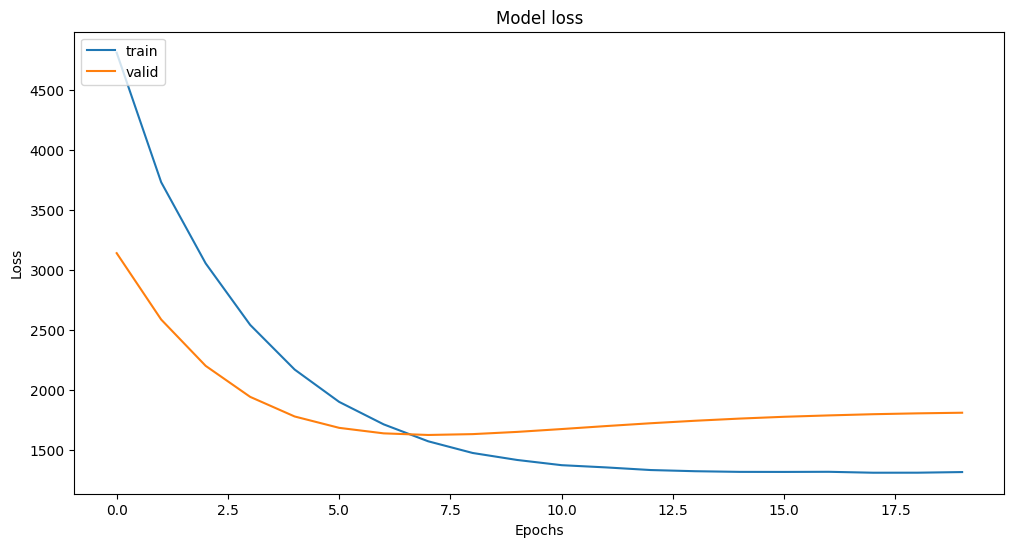

In [18]:
# Plot the accuracy and loss
plt.figure(figsize=(12,6))
plt.title('Model loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'valid'], loc='upper left')

max_loss = np.max(history.history['loss'])
min_loss = np.min(history.history['loss'])
print("Maximum Loss : {:.4f}".format(max_loss))
print("")
print("Minimum Loss : {:.4f}".format(min_loss))
print("")
print("Loss difference : {:.4f}".format((max_loss - min_loss)))

In [ ]:
predictions = model.predict(y_test)
predictions

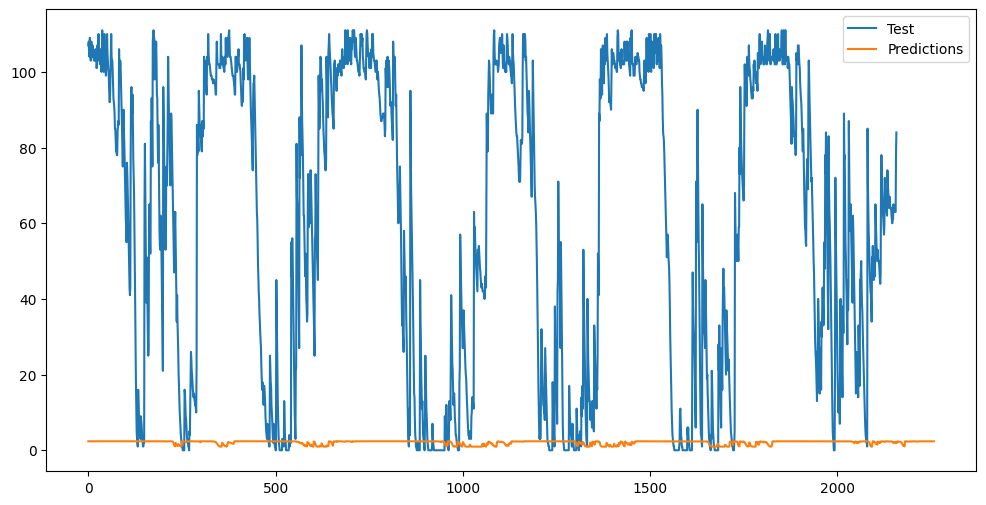

In [20]:
plt.figure(figsize=(12,6))
# plt.plot(list(y_test[100:]), label="Test")
plt.plot(list(predictions), label="Predictions")
plt.legend()
plt.show()

In [21]:
VALID_AND_TEST_SIZE = 0.1
TIME_WINDOW=10
FORECAST_DISTANCE=3

In [22]:
df2 = reindexed_df[['BF10']]
targetcol = "BF10"
targetcol_series = df2[targetcol]

Train-test split

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_else, targetcol_series_train, targetcol_series_else = train_test_split(df2, 
                                   targetcol_series, 
                                   test_size=VALID_AND_TEST_SIZE*2, 
                                   shuffle=False)
X_valid, X_test, targetcol_series_valid, targetcol_series_test = train_test_split(X_else, targetcol_series_else, test_size=0.5, shuffle=False)

In [24]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print()
print(targetcol_series_train.shape)
print(targetcol_series_valid.shape)
print(targetcol_series_test.shape)

(9057, 1)
(1132, 1)
(1133, 1)

(9057,)
(1132,)
(1133,)


### Sliding window

Fitting X and y onto the time series: 
* first X sample has to fit TIME_WINDOW at the beginning
* last y sample has to fit FORECAST_DISTANCE-1 into the future 
    > * If `FORECAST_DISTANCE == 1`, then we just take the target column, nonshifted.
    > * If `FORECAST_DISTANCE == 2`, then we just take the target column, shifted BACK by 1 (=next row's value, `shift(-1)`), etc.

In [25]:
def sliding_window_2D_from_df(df, targetcol_series, TIME_WINDOW, FORECAST_DISTANCE):
    X_df = pd.concat([df.shift(i) for i in range(1,TIME_WINDOW+1)], axis=1)\
                      .iloc[TIME_WINDOW : len(df) - FORECAST_DISTANCE + 1]
    X_df.columns = pd.MultiIndex.from_product([range(1,TIME_WINDOW+1), df.columns])
    X_df.rename_axis(["lag", "variable"], axis=1, inplace=True)

    y_series = targetcol_series.shift( -FORECAST_DISTANCE + 1 )\
                      .iloc[ TIME_WINDOW : len(df) - FORECAST_DISTANCE + 1 ]
    return X_df, y_series

In [26]:
def spot_check_sliding_window_2D(X_df, y_series, df, target_series, FORECAST_DISTANCE=1):
    TIME_WINDOW = X_df.shape[1] // df.shape[1]
    display(X_df.head(1).iloc[:,[*list(range(2*df.shape[1])), *list(range(-2*df.shape[1],0))]])
    print("The following should be the first two lagged values:")
    display(df.iloc[:TIME_WINDOW].tail(2))
    print("The following should be the last two lagged values:")
    display(df.head(2))

    print(f"\nThe target (FORECAST_DISTANCE={FORECAST_DISTANCE}):")
    display(y_series.iloc[:10].to_frame().T)
    print(f"The actual values from the end of the first time window (TIME_WINDOW={TIME_WINDOW}):")
    display(target_series.iloc[TIME_WINDOW:].iloc[:FORECAST_DISTANCE+9].to_frame().T)

In [27]:
X_df_train, y_train = sliding_window_2D_from_df(X_train, targetcol_series_train, TIME_WINDOW, FORECAST_DISTANCE)
X_df_valid, y_valid = sliding_window_2D_from_df(X_valid, targetcol_series_valid, TIME_WINDOW, FORECAST_DISTANCE)
X_df_test, y_test = sliding_window_2D_from_df(X_test, targetcol_series_test, TIME_WINDOW, FORECAST_DISTANCE)

In [28]:
## check, just to be on the safe side...

assert y_train.notna().all()
assert y_valid.notna().all()
assert y_test.notna().all()

assert X_train.notna().all().all()
assert X_valid.notna().all().all()
assert X_test.notna().all().all()

Spot-checking...

In [29]:
spot_check_sliding_window_2D(X_df_train, y_train, X_train, targetcol_series_train, FORECAST_DISTANCE)

lag,1,2,9,10
variable,BF10,BF10,BF10,BF10
DATUM,,,,
1991-01-11,108.0,107.0,110.0,102.0


The following should be the first two lagged values:


,BF10
DATUM,
1991-01-09,107.0
1991-01-10,108.0


The following should be the last two lagged values:


,BF10
DATUM,
1991-01-01,102.0
1991-01-02,110.0



The target (FORECAST_DISTANCE=3):


DATUM,1991-01-11,1991-01-12,1991-01-13,1991-01-14,1991-01-15,1991-01-16,1991-01-17,1991-01-18,1991-01-19,1991-01-20
BF10,102.0,101.0,99.0,98.0,97.0,96.0,102.0,103.0,105.0,104.0


The actual values from the end of the first time window (TIME_WINDOW=10):


DATUM,1991-01-11,1991-01-12,1991-01-13,1991-01-14,1991-01-15,1991-01-16,1991-01-17,1991-01-18,1991-01-19,1991-01-20,1991-01-21,1991-01-22
BF10,103.0,103.0,102.0,101.0,99.0,98.0,97.0,96.0,102.0,103.0,105.0,104.0


### Sliding window into (samples, timesteps, variables) shaped array


In [30]:
## where we are at...: something we can feed into generic models (e.g., feedfwd NN's, sklearn models like RF...)
X_df_train

lag,1,2,3,4,5,6,7,8,9,10
variable,BF10,BF10,BF10,BF10,BF10,BF10,BF10,BF10,BF10,BF10
DATUM,,,,,,,,,,
1991-01-11,108.0,107.0,110.0,103.0,103.0,109.0,106.0,110.0,110.0,102.0
1991-01-12,103.0,108.0,107.0,110.0,103.0,103.0,109.0,106.0,110.0,110.0
1991-01-13,103.0,103.0,108.0,107.0,110.0,103.0,103.0,109.0,106.0,110.0
1991-01-14,102.0,103.0,103.0,108.0,107.0,110.0,103.0,103.0,109.0,106.0
1991-01-15,101.0,102.0,103.0,103.0,108.0,107.0,110.0,103.0,103.0,109.0
...,...,...,...,...,...,...,...,...,...,...
2015-10-12,97.0,101.0,104.0,95.0,91.0,93.0,77.0,79.0,80.0,81.0
2015-10-13,95.0,97.0,101.0,104.0,95.0,91.0,93.0,77.0,79.0,80.0


In [31]:
def rolled_X_from_2D_sliding_window_df(X_df, timesteps):
    X_rolled = X_df.values.reshape(X_df.shape[0], timesteps, -1)
    return X_rolled

In [32]:
X_rolled_train = rolled_X_from_2D_sliding_window_df(X_df_train, TIME_WINDOW)
X_rolled_valid = rolled_X_from_2D_sliding_window_df(X_df_valid, TIME_WINDOW)
X_rolled_test = rolled_X_from_2D_sliding_window_df(X_df_test, TIME_WINDOW)

In [33]:
print(y_train.shape)
print(X_df_train.shape)
print(X_rolled_train.shape)

print()

print(y_test.shape)
print(X_df_test.shape)
print(X_rolled_test.shape)

(9045,)
(9045, 10)
(9045, 10, 1)

(1121,)
(1121, 10)
(1121, 10, 1)


Automated checking of first samples...

In [34]:
def autocheck_first_sample(orig_df, X_rolled, targetcol_series, y):
    np.testing.assert_equal(orig_df[:TIME_WINDOW].iloc[::-1].values,
                            X_rolled[0])
    np.testing.assert_equal(pd.Series(targetcol_series).iloc[TIME_WINDOW-1+FORECAST_DISTANCE],
                            pd.Series(y).iloc[0])

In [35]:
autocheck_first_sample(X_train, X_rolled_train, targetcol_series_train, y_train)
autocheck_first_sample(X_valid, X_rolled_valid, targetcol_series_valid, y_valid)
autocheck_first_sample(X_test, X_rolled_test, targetcol_series_test, y_test)

Spot checking...

In [36]:
def spot_check_3D_Xarray(X_rolled, X_df):
    for sample_idx in [0, 1, -2, -1]:
        print(f"SAMPLE NR. {sample_idx}:")
        print("In derived and in rolled data, for time steps 0,1,...-2,-1:")
        display( X_df.iloc[[sample_idx], [0, 1, 2, 3, -4,-3, -2, -1]].round(4) )
        print(X_rolled[sample_idx][0].round(4), X_rolled[sample_idx][1].round(4), 
            "...",  X_rolled[sample_idx][-2].round(4),  X_rolled[sample_idx][-1].round(4))
        print("\n")

In [37]:
X_rolled_train[0][-1].round(4)

array([102.])

In [38]:
spot_check_3D_Xarray(X_rolled_train, X_df_train)

SAMPLE NR. 0:
In derived and in rolled data, for time steps 0,1,...-2,-1:


lag,1,2,3,4,7,8,9,10
variable,BF10,BF10,BF10,BF10,BF10,BF10,BF10,BF10
DATUM,,,,,,,,
1991-01-11,108.0,107.0,110.0,103.0,106.0,110.0,110.0,102.0


[108.] [107.] ... [110.] [102.]


SAMPLE NR. 1:
In derived and in rolled data, for time steps 0,1,...-2,-1:


lag,1,2,3,4,7,8,9,10
variable,BF10,BF10,BF10,BF10,BF10,BF10,BF10,BF10
DATUM,,,,,,,,
1991-01-12,103.0,108.0,107.0,110.0,109.0,106.0,110.0,110.0


[103.] [108.] ... [110.] [110.]


SAMPLE NR. -2:
In derived and in rolled data, for time steps 0,1,...-2,-1:


lag,1,2,3,4,7,8,9,10
variable,BF10,BF10,BF10,BF10,BF10,BF10,BF10,BF10
DATUM,,,,,,,,
2015-10-15,108.0,94.0,95.0,97.0,95.0,91.0,93.0,77.0


[108.] [94.] ... [93.] [77.]


SAMPLE NR. -1:
In derived and in rolled data, for time steps 0,1,...-2,-1:


lag,1,2,3,4,7,8,9,10
variable,BF10,BF10,BF10,BF10,BF10,BF10,BF10,BF10
DATUM,,,,,,,,
2015-10-16,111.0,108.0,94.0,95.0,104.0,95.0,91.0,93.0


[111.] [108.] ... [91.] [93.]




## Building LSTM networks

In [39]:
## Quick data prep that is intuitively a good starting point

VALID_AND_TEST_SIZE = 0.1
TIME_WINDOW=100
FORECAST_DISTANCE=30

targetcol = "BF10"
targetcol_series = df2[targetcol]

## train valid test split
X_train, X_else, targetcol_series_train, targetcol_series_else = train_test_split(df2[["BF10"]], 
                                   targetcol_series, 
                                   test_size=VALID_AND_TEST_SIZE*2, 
                                   shuffle=False)
X_valid, X_test, targetcol_series_valid, targetcol_series_test = train_test_split(X_else, targetcol_series_else, test_size=0.5, shuffle=False)

## sliding window
X_df_train, y_train = sliding_window_2D_from_df(X_train, targetcol_series_train, TIME_WINDOW, FORECAST_DISTANCE)
X_df_valid, y_valid = sliding_window_2D_from_df(X_valid, targetcol_series_valid, TIME_WINDOW, FORECAST_DISTANCE)
X_df_test, y_test = sliding_window_2D_from_df(X_test, targetcol_series_test, TIME_WINDOW, FORECAST_DISTANCE)

## for lstm
X_rolled_train = rolled_X_from_2D_sliding_window_df(X_df_train, TIME_WINDOW)
X_rolled_valid = rolled_X_from_2D_sliding_window_df(X_df_valid, TIME_WINDOW)
X_rolled_test = rolled_X_from_2D_sliding_window_df(X_df_test, TIME_WINDOW)

autocheck_first_sample(X_train, X_rolled_train, targetcol_series_train, y_train)
autocheck_first_sample(X_valid, X_rolled_valid, targetcol_series_valid, y_valid)
autocheck_first_sample(X_test, X_rolled_test, targetcol_series_test, y_test)

print(X_rolled_train.shape)

(8928, 100, 1)


###### Aside: About the LSTM layer in keras: return_sequences vs. return_state

In [40]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras import backend as be
import tensorflow as tf

## we use 10 samples
## and 4 units (hidden state is 4-long for each time step)

tf.random.set_seed(42)
be.clear_session()
input_layer = X_rolled_train[:10]

whole_seq_output, final_memory_state, final_carry_state =  LSTM(4, return_sequences=True, return_state=True)(input_layer)

tf.random.set_seed(42)
be.clear_session()
whole_seq_output2 =  LSTM(4, return_sequences=True, return_state=False)(input_layer)

tf.random.set_seed(42)
be.clear_session()
out_last =  LSTM(4, return_sequences=False, return_state=False)(input_layer)

tf.random.set_seed(42)
be.clear_session()
whole_seq_output3, final_memory_state3, final_carry_state3 =  LSTM(4, return_sequences=False, return_state=True)(input_layer)


print("return_sequences=True, return_state=True")
print(whole_seq_output.shape)
print(final_memory_state.shape)
print(final_carry_state.shape)

print()
print("return_sequences=True, return_state=False")
print(whole_seq_output2.shape)

print()
print("return_sequences=False, return_state=False")
print(out_last.shape)

print()
print("return_sequences=False, return_state=True")
print(whole_seq_output3.shape)
print(final_memory_state3.shape)
print(final_carry_state3.shape)



return_sequences=True, return_state=True
(10, 100, 4)
(10, 4)
(10, 4)

return_sequences=True, return_state=False
(10, 100, 4)

return_sequences=False, return_state=False
(10, 4)

return_sequences=False, return_state=True
(10, 4)
(10, 4)
(10, 4)


In [41]:
print("For first sample...\n")
print("\treturn_sequences=True, return_state=True")
print("\tlast two time step hidden state output:", np.array(whole_seq_output[0][-2:]))
print("\tfinal hidden state (=output):", np.array(final_memory_state[0]))
print("\tfinal cell state:", np.array(final_carry_state[0]))

print()
print("\treturn_sequences=True, return_state=False")
print("\tlast two time step hidden state output:", np.array(whole_seq_output2[0][-2:]))

print()
print("\treturn_sequences=False, return_state=False")
print("\tfinal hidden state (=output):", np.array(out_last[0]))

print()
print("\treturn_sequences=False, return_state=True")
print("\thidden state:", np.array(whole_seq_output3[0]))
print("\tfinal hidden state (=output):", np.array(final_memory_state3[0]))
print("\tfinal cell state:", np.array(final_carry_state3[0]))



For first sample...

	return_sequences=True, return_state=True
	last two time step hidden state output: [[ 9.1327063e-05  6.5168448e-10  8.0813161e-06 -2.9710939e-02]
 [ 9.1327063e-05  3.0366392e-09  7.9149540e-06 -3.7976362e-02]]
	final hidden state (=output): [ 9.1327063e-05  3.0366392e-09  7.9149540e-06 -3.7976362e-02]
	final cell state: [ 9.1327063e-05  9.9827507e+01  1.0633796e-05 -3.7994638e-02]

	return_sequences=True, return_state=False
	last two time step hidden state output: [[ 1.0000000e+00 -1.0000000e+00 -1.1326313e-22  7.6159418e-01]
 [ 1.0000000e+00 -1.0000000e+00 -4.2939871e-21  7.6159418e-01]]

	return_sequences=False, return_state=False
	final hidden state (=output): [ 1.         -0.9999362   1.          0.00247575]

	return_sequences=False, return_state=True
	hidden state: [-7.6159418e-01  5.3032989e-19 -4.1620115e-08  2.3803922e-25]
	final hidden state (=output): [-7.6159418e-01  5.3032989e-19 -4.1620115e-08  2.3803922e-25]
	final cell state: [-1.000000e+00  5.303299

###### Model definition

In [42]:
#---- Hyperparams and settings ----

EPOCHS = 30
BATCH_SIZE = 200
LEARNING_RATE = 1
LSTM_CELL_SIZE = 300
LSTM_CELL_SIZE2 = 100

In [43]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras import backend as be
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

## number of input variables: the final dimension in the 3D prepared data (index 2)
column_count=X_rolled_train.shape[2]

be.clear_session()

model = Sequential()

### !!!return_sequences=True if recurrent layer follows
model.add( LSTM(LSTM_CELL_SIZE, return_sequences=True, input_shape=(TIME_WINDOW,column_count)))

### default return_sequences=False if Dense layer follows
model.add( LSTM(LSTM_CELL_SIZE2) )

### the output layer:
model.add(  Dense(1) )  ## Question: what is the activation here?

optimizer = Adam(learning_rate=LEARNING_RATE)

## remember, we're doing regression, so choose loss (and output layer) accordingly!
model.compile(loss='mean_squared_error', optimizer=optimizer)

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 300)          362400    
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 522,901
Trainable params: 522,901
Non-trainable params: 0
_________________________________________________________________
None


In [44]:
history = model.fit(x=X_rolled_train,
                    y=y_train, 
                    batch_size=BATCH_SIZE, 
                    validation_data=(X_rolled_valid,y_valid), 
                    epochs=10,
                    verbose=1, 
                    shuffle=False,
                    )

Epoch 1/10
45/45 [==============================] - 29s 572ms/step - loss: 1442.7236 - val_loss: 2159.2646
Epoch 2/10
45/45 [==============================] - 27s 593ms/step - loss: 1366.4640 - val_loss: 2244.2566
Epoch 3/10
45/45 [==============================] - 26s 576ms/step - loss: 1375.3835 - val_loss: 2255.7761
Epoch 4/10
27/45 [=================>............] - ETA: 13s - loss: 1294.3987

: 

: 

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

In [ ]:
predictions = model.predict(X_rolled_test).flatten()

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(list(X_test[TIME_WINDOW:]), label="Test")
plt.plot(list(predictions), label="Predictions")
plt.legend()
plt.show()